In [ ]:
%cd /content/drive/MyDrive/mosaic/ps2/
root = "/content/drive/MyDrive/mosaic/ps2/"

/content/drive/MyDrive/mosaic/ps2


In [ ]:
#! git clone https://github.com/ultralytics/yolov5
%cd yolov5/
! git pull https://github.com/ultralytics/yolov5
%cd ..

/content/drive/MyDrive/mosaic/ps2/yolov5
From https://github.com/ultralytics/yolov5
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content/drive/MyDrive/mosaic/ps2


In [ ]:
!pip install -r yolov5/requirements.txt

In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
random.seed(108)

In [ ]:
'''for name in os.listdir("archive/images/"):
  if name.split('.')[-1] == "PNG":
    new_name = name.split('.')[0] + ".png"
    os.rename("archive/images/"+name, "archive/images/"+new_name)'''

'for name in os.listdir("archive/images/"):\n  if name.split(\'.\')[-1] == "PNG":\n    new_name = name.split(\'.\')[0] + ".png"\n    os.rename("archive/images/"+name, "archive/images/"+new_name)'

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
info = extract_info_from_xml("archive/xml_labels/1.xml")

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"pool": 0,}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("archive/annotations", info_dict['filename'].split('.')[0] + ".txt")
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('archive/xml_labels', x) for x in os.listdir('archive/xml_labels') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('archive/annotations', x) for x in os.listdir('archive/annotations') if x[-3:] == "txt"]

100%|██████████| 172/172 [00:02<00:00, 67.61it/s] 


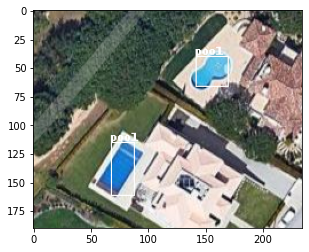

In [ ]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("archive/annotations", "archive/images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
annotations = [os.path.join('archive/annotations', x) for x in os.listdir('archive/annotations') if x[-3:] == "txt"]
images = [os.path.join('archive/images', x) for x in os.listdir('archive/images') if x[-3:] == "png"]

In [ ]:
no_obj = set([s.split('/')[-1].split('.')[0] for s in images]).difference(set([s.split('/')[-1].split('.')[0] for s in annotations]))
files = ["archive/annotations/" + s + '.txt' for s in no_obj]
for file in files:
  open(file, 'a').close()

In [ ]:
annotations = [os.path.join('archive/annotations', x) for x in os.listdir('archive/annotations') if x[-3:] == "txt"]

In [ ]:
images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 69)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 69)

In [ ]:
!mkdir archive/images/train archive/images/val archive/images/test archive/annotations/train archive/annotations/val archive/annotations/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'archive/images/train')
move_files_to_folder(val_images, 'archive/images/val/')
move_files_to_folder(test_images, 'archive/images/test/')
move_files_to_folder(train_annotations, 'archive/annotations/train/')
move_files_to_folder(val_annotations, 'archive/annotations/val/')
move_files_to_folder(test_annotations, 'archive/annotations/test/')

In [ ]:
os.rename("archive/annotations", "archive/labels")

In [ ]:
!python yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-med.yaml --batch 32 --epochs 100 --data swimming_pool_data.yaml --weights yolov5s.pt --workers 24 --name yolo_swimming_pool


train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=swimming_pool_data.yaml, hyp=hyp.scratch-med.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolo_swimming_pool, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
From https://github.com/ultralytics/yolov5
   4bb7eb8..74aaab3  master     -> origin/master
YOLOv5 🚀 v6.1-129-g74aaab3 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls

In [ ]:
!python yolov5/val.py --weights yolov5/runs/train/yolo_swimming_pool/weights/best.pt --data swimming_pool_data.yaml --task test --name yolo_swimming_pool

val: data=/content/drive/MyDrive/mosaic/ps2/yolov5/data/swimming_pool_data.yaml, weights=['yolov5/runs/train/yolo_swimming_pool/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=yolo_swimming_pool, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-129-g74aaab3 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/drive/MyDrive/mosaic/ps2/yolov5/../archive/labels/test' images and labels...29 found, 0 missing, 12 empty, 0 corrupt: 100% 29/29 [00:00<00:00, 169.42it/s]
test: New cache created: /content/drive/MyDrive/mosaic/ps2/yolov5/../archive/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:01<00:00,  1.7